In [135]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import numpy as np
import os
from pathlib import Path
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [136]:
import numpy as np
import pandas as pd
import os
import alpaca_trade_api as tradeapi
import datetime as dt
import pytz

class MCSimulation:
    """
    A Python class for runnning Monte Carlo simulation on portfolio price data. 
    
    ...
    
    Attributes
    ----------
    portfolio_data : pandas.DataFrame
        portfolio dataframe
    weights: list(float)
        portfolio investment breakdown
    nSim: int
        number of samples in simulation
    nTrading: int
        number of trading days to simulate
    simulated_return : pandas.DataFrame
        Simulated data from Monte Carlo
    confidence_interval : pandas.Series
        the 95% confidence intervals for simulated final cumulative returns
        
    """
    
    def __init__(self, portfolio_data, weights="", num_simulation=1000, num_trading_days=252):
        """
        Constructs all the necessary attributes for the MCSimulation object.
        Parameters
        ----------
        portfolio_data: pandas.DataFrame
            DataFrame containing stock price information from Alpaca API
        weights: list(float)
            A list fractions representing percentage of total investment per stock. DEFAULT: Equal distribution
        num_simulation: int
            Number of simulation samples. DEFAULT: 1000 simulation samples
        num_trading_days: int
            Number of trading days to simulate. DEFAULT: 252 days (1 year of business days)
        """
        
        # Check to make sure that all attributes are set
        if not isinstance(portfolio_data, pd.DataFrame):
            raise TypeError("portfolio_data must be a Pandas DataFrame")
            
        # Set weights if empty, otherwise make sure sum of weights equals one.
        if weights == "":
            num_stocks = len(portfolio_data.columns.get_level_values(0).unique())
            weights = [1.0/num_stocks for s in range(0,num_stocks)]
        else:
            if round(sum(weights),2) < .99:
                raise AttributeError("Sum of portfolio weights must equal one.")
        
        # Calculate daily return if not within dataframe
        if not "daily_return" in portfolio_data.columns.get_level_values(1).unique():
            close_df = portfolio_data.xs('close',level=1,axis=1).pct_change()
            tickers = portfolio_data.columns.get_level_values(0).unique()
            column_names = [(x,"daily_return") for x in tickers]
            close_df.columns = pd.MultiIndex.from_tuples(column_names)
            portfolio_data = portfolio_data.merge(close_df,left_index=True,right_index=True).reindex(columns=tickers,level=0)    
        
        # Set class attributes
        self.portfolio_data = portfolio_data
        self.weights = weights
        self.nSim = num_simulation
        self.nTrading = num_trading_days
        self.simulated_return = ""
        
    def calc_cumulative_return(self):
        """
        Calculates the cumulative return of a stock over time using a Monte Carlo simulation (Brownian motion with drift).
        """
        
        # Get closing prices of each stock
        last_prices = self.portfolio_data.xs('close',level=1,axis=1)[-1:].values.tolist()[0]
        
        # Calculate the mean and standard deviation of daily returns for each stock
        daily_returns = self.portfolio_data.xs('daily_return',level=1,axis=1)
        mean_returns = daily_returns.mean().tolist()
        std_returns = daily_returns.std().tolist()
        
        # Initialize empty Dataframe to hold simulated prices
        portfolio_cumulative_returns = pd.DataFrame()
        
        # Run the simulation of projecting stock prices 'nSim' number of times
        for n in range(self.nSim):
        
            if n % 10 == 0:
                print(f"Running Monte Carlo simulation number {n}.")
        
            # Create a list of lists to contain the simulated values for each stock
            simvals = [[p] for p in last_prices]
    
            # For each stock in our data:
            for s in range(len(last_prices)):

                # Simulate the returns for each trading day
                for i in range(self.nTrading):
        
                    # Calculate the simulated price using the last price within the list
                    simvals[s].append(simvals[s][-1] * (1 + np.random.normal(mean_returns[s], std_returns[s])))
    
            # Calculate the daily returns of simulated prices
            sim_df = pd.DataFrame(simvals).T.pct_change()
    
            # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
            sim_df = sim_df.dot(self.weights)
    
            # Calculate the normalized, cumulative return series
            portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
        
        # Set attribute to use in plotting
        self.simulated_return = portfolio_cumulative_returns
        
        # Calculate 95% confidence intervals for final cumulative returns
        self.confidence_interval = portfolio_cumulative_returns.iloc[-1, :].quantile(q=[0.025, 0.975])
        
        return portfolio_cumulative_returns
    
    def plot_simulation(self):
        """
        Visualizes the simulated stock trajectories using calc_cumulative_return method.
        """ 
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
            
        # Use Pandas plot function to plot the return data
        plot_title = f"{self.nSim} Simulations of Cumulative Portfolio Return Trajectories Over the Next {self.nTrading} Trading Days."
        return self.simulated_return.plot(legend=None,title=plot_title)
    
    def plot_distribution(self):
        """
        Visualizes the distribution of cumulative returns simulated using calc_cumulative_return method.
        """
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
        
        # Use the `plot` function to create a probability distribution histogram of simulated ending prices
        # with markings for a 95% confidence interval
        plot_title = f"Distribution of Final Cumuluative Returns Across All {self.nSim} Simulations"
        plt = self.simulated_return.iloc[-1, :].plot(kind='hist', bins=10,density=True,title=plot_title)
        plt.axvline(self.confidence_interval.iloc[0], color='r')
        plt.axvline(self.confidence_interval.iloc[1], color='r')
        return plt
    
    def summarize_cumulative_return(self):
        """
        Calculate final summary statistics for Monte Carlo simulated stock data.
        
        """
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
            
        metrics = self.simulated_return.iloc[-1].describe()
        ci_series = self.confidence_interval
        ci_series.index = ["95% CI Lower","95% CI Upper"]
        return metrics.append(ci_series)


In [137]:
from dotenv import load_dotenv
load_dotenv()

True

###### from dotenv import load_dotenv
load_dotenv()

In [138]:
# Set Alpaca API key and secret
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET")

api = tradeapi.REST(
   alpaca_api_key,
   alpaca_secret_key,
    api_version = "v2"
)


In [139]:
#Top Stocks for each sector 

In [140]:

# Set the tickers
tickers =  ["SPY", "BRK.B", "PRU", "JNJ", "BAC", "RTX", "DIS", "RIO","WMT","NEE","ORCL","PG" ]
timeframe = "1D"

# Set start and end datetimes 
start_date = pd.Timestamp("2020-07-30", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-07-30", tz="America/New_York").isoformat()


# Get historical data for all stocks
df_ticker = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
 
).df

# Display sample data
df_ticker.head()

BAC                                    BRK.B  \
                            open     high    low  close    volume    open   
time                                                                        
2021-03-10 00:00:00-05:00  36.54  37.5300  36.37  37.36  48273465  260.30   
2021-03-11 00:00:00-05:00  37.27  37.7900  36.85  37.24  41694794  264.22   
2021-03-12 00:00:00-05:00  37.92  38.1766  37.58  37.94  43214615  262.40   
2021-03-15 00:00:00-04:00  38.03  38.0700  37.22  37.74  44223838  260.31   
2021-03-16 00:00:00-04:00  37.42  37.7200  36.97  37.64  44599006  254.53   

                                                              ...     SPY  \
                             high       low   close   volume  ...    open   
time                                                          ...           
2021-03-10 00:00:00-05:00  267.50  259.6400  263.87  8005789  ...  389.69   
2021-03-11 00:00:00-05:00  264.80  260.4199  260.99  5310819  ...  392.23   
2021-03-12 00:00:00-05:00  264.65  259.6700  260.02  3933652  ...  392.07   
2021-03-15 00:00:00-04:00  260.44  253.5200  254.49  5730004  ...  394.33   
2021-03-16 00:00:00-04:00  254.53  249.8200  251.50  5619337  ...  397.07   

                                                                      WMT  \
                              high       low     close     volume    open   
time                                                                        
2021-03-10 00:00:00-05:00  391.400  388.1702  389.5199  101349197  128.86   
2021-03-11 00:00:00-05:00  395.650  391.7400  393.5000   77022138  133.36   
2021-03-12 00:00:00-05:00  394.210  391.2000  394.0900   56997361  132.52   
2021-03-15 00:00:00-04:00  396.685  392.0300  396.4700   64471980  134.74   
2021-03-16 00:00:00-04:00  397.830  395.0800  395.9400   65719794  132.82   

                                                               
                             high       low   close    volume  
time                                                           
2021-03-10 00:00:00-05:00  133.05  128.4700  132.18  14000990  
2021-03-11 00:00:00-05:00  133.49  131.5300  132.13  11004708  
2021-03-12 00:00:00-05:00  134.52  132.0801  134.10   8639807  
2021-03-15 00:00:00-04:00  134.75  132.8250  133.43   6548235  
2021-03-16 00:00:00-04:00  134.28  132.8200  133.39   5620005  

[5 rows x 60 columns]

In [141]:
df_closing_prices = pd.DataFrame()

# Fetch the closing prices for all the tickers
for ticker in tickers:
    df_closing_prices[ticker] = df_ticker[ticker]["close"]

# Drop the time component of the date
df_closing_prices.index = df_closing_prices.index.date

# Display sample data
df_closing_prices.head()

,SPY,BRK.B,PRU,JNJ,BAC,RTX,DIS,RIO,WMT,NEE,ORCL,PG
2021-03-10,389.5199,263.87,92.80,159.09,37.36,76.55,195.05,80.20,132.18,74.46,72.11,127.35
2021-03-11,393.5000,260.99,92.39,159.15,37.24,77.03,196.75,82.50,132.13,74.85,67.42,126.89
2021-03-12,394.0900,260.02,93.88,159.63,37.94,78.52,197.06,81.26,134.10,75.67,67.18,128.15
2021-03-15,396.4700,254.49,93.80,160.38,37.74,79.57,196.73,79.58,133.43,75.48,67.72,128.55
2021-03-16,395.9400,251.50,91.39,161.31,37.64,78.23,194.22,78.79,133.39,75.38,66.84,128.91


In [142]:
df_daily_returns  = df_closing_prices.pct_change().dropna()
df_daily_returns.head()

,SPY,BRK.B,PRU,JNJ,BAC,RTX,DIS,RIO,WMT,NEE,ORCL,PG
2021-03-11,0.010218,-0.010914,-0.004418,0.000377,-0.003212,0.006270,0.008716,0.028678,-0.000378,0.005238,-0.065040,-0.003612
2021-03-12,0.001499,-0.003717,0.016127,0.003016,0.018797,0.019343,0.001576,-0.015030,0.014910,0.010955,-0.003560,0.009930
2021-03-15,0.006039,-0.021268,-0.000852,0.004698,-0.005271,0.013372,-0.001675,-0.020674,-0.004996,-0.002511,0.008038,0.003121
2021-03-16,-0.001337,-0.011749,-0.025693,0.005799,-0.002650,-0.016841,-0.012759,-0.009927,-0.000300,-0.001325,-0.012995,0.002800
2021-03-17,0.003233,0.002147,0.019586,-0.002542,0.008236,0.017257,0.005252,-0.001015,-0.008172,-0.031706,-0.009425,-0.003879


<AxesSubplot:ylabel='Frequency'>

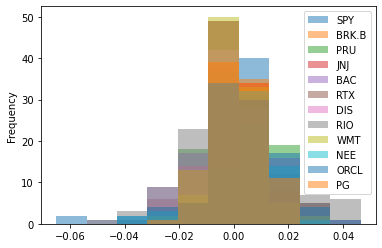

In [143]:
df_daily_returns.plot.hist(alpha=0.5)

<AxesSubplot:ylabel='Density'>

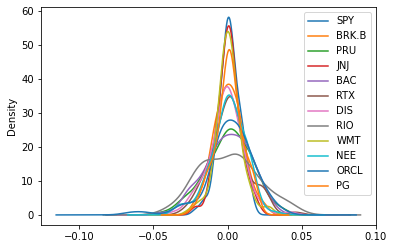

In [144]:
df_daily_returns.plot.density()

In [145]:
# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetime.
start_date = pd.Timestamp("2020-07-30", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-07-30", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["SPY","BRK.B","JNJ","PG","WMT"]

# Get historical price data
winners_df_ticker = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000
).df

# Display sample data
winners_df_ticker.head()

BRK.B                                      JNJ  \
                             open    high     low   close   volume    open   
time                                                                         
2020-07-30 00:00:00-04:00  193.43  194.57  192.25  194.30  7833392  147.44   
2020-07-31 00:00:00-04:00  195.06  196.00  193.33  195.82  9690065  146.66   
2020-08-03 00:00:00-04:00  197.28  200.11  196.00  199.14  8444685  146.39   
2020-08-04 00:00:00-04:00  198.97  200.31  198.11  200.31  6409839  146.99   
2020-08-05 00:00:00-04:00  201.44  204.69  201.00  203.62  9195934  149.10   

                                                              ...     SPY  \
                             high       low   close   volume  ...    open   
time                                                          ...           
2020-07-30 00:00:00-04:00  147.50  146.1400  146.91  9763807  ...  321.90   
2020-07-31 00:00:00-04:00  147.45  143.9600  145.83  9793444  ...  325.90   
2020-08-03 00:00:00-04:00  147.58  146.1500  147.35  5316205  ...  328.32   
2020-08-04 00:00:00-04:00  147.22  145.8247  147.21  6513500  ...  327.86   
2020-08-05 00:00:00-04:00  149.31  147.8000  148.39  9032563  ...  331.47   

                                                                 WMT           \
                             high     low   close     volume    open     high   
time                                                                            
2020-07-30 00:00:00-04:00  324.41  319.64  323.98  106103025  129.42  130.420   
2020-07-31 00:00:00-04:00  326.61  321.33  326.55  129516546  129.65  130.090   
2020-08-03 00:00:00-04:00  329.62  327.73  328.76   71741125  129.91  130.115   
2020-08-04 00:00:00-04:00  330.06  327.86  330.03   73684427  129.65  131.710   
2020-08-05 00:00:00-04:00  332.39  331.18  332.06   72846458  130.45  130.750   

                                                       
                                low   close    volume  
time                                                   
2020-07-30 00:00:00-04:00  128.7200  130.11   8392139  
2020-07-31 00:00:00-04:00  127.6200  129.43  11376858  
2020-08-03 00:00:00-04:00  128.2713  129.30   7181839  
2020-08-04 00:00:00-04:00  128.9400  131.62  11032656  
2020-08-05 00:00:00-04:00  128.8300  129.80  15735392  

[5 rows x 25 columns]

In [146]:
wn_closing_prices = pd.DataFrame()

# Fetch the closing prices for all the tickers
for ticker in tickers:
    wn_closing_prices[ticker] = winners_df_ticker[ticker]["close"]

# Drop the time component of the date
wn_closing_prices.index = wn_closing_prices.index.date

# Display sample data
wn_closing_prices.head()

,SPY,BRK.B,JNJ,PG,WMT
2020-07-30,323.98,194.30,146.91,131.44,130.11
2020-07-31,326.55,195.82,145.83,131.06,129.43
2020-08-03,328.76,199.14,147.35,131.33,129.30
2020-08-04,330.03,200.31,147.21,133.80,131.62
2020-08-05,332.06,203.62,148.39,133.45,129.80


In [147]:
wn_daily_returns  = wn_closing_prices.pct_change().dropna()
wn_daily_returns.head()

,SPY,BRK.B,JNJ,PG,WMT
2020-07-31,0.007933,0.007823,-0.007351,-0.002891,-0.005226
2020-08-03,0.006768,0.016954,0.010423,0.002060,-0.001004
2020-08-04,0.003863,0.005875,-0.000950,0.018808,0.017943
2020-08-05,0.006151,0.016524,0.008016,-0.002616,-0.013828
2020-08-06,0.006776,0.007219,-0.005661,-0.005545,-0.003467


<AxesSubplot:ylabel='Frequency'>

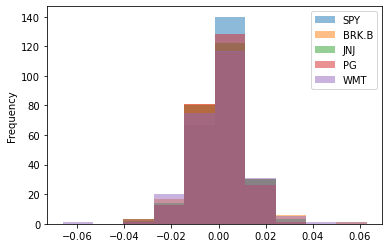

In [148]:
wn_daily_returns.plot.hist(alpha=0.5)

<AxesSubplot:ylabel='Density'>

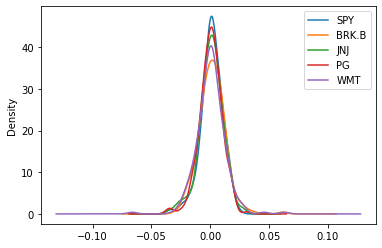

In [149]:
wn_daily_returns.plot.density()

5 Years of Simulation of the 5 Top Stocks of equal weights

In [150]:
MC_even_dist = MCSimulation(
    portfolio_data = winners_df_ticker,
    weights = [.20,.20,.20,.20,.20],
    num_simulation = 1000,
    num_trading_days = 252*5
)
MC_even_dist.portfolio_data.head()

BRK.B                                   \
                             open    high     low   close   volume   
time                                                                 
2020-07-30 00:00:00-04:00  193.43  194.57  192.25  194.30  7833392   
2020-07-31 00:00:00-04:00  195.06  196.00  193.33  195.82  9690065   
2020-08-03 00:00:00-04:00  197.28  200.11  196.00  199.14  8444685   
2020-08-04 00:00:00-04:00  198.97  200.31  198.11  200.31  6409839   
2020-08-05 00:00:00-04:00  201.44  204.69  201.00  203.62  9195934   

                                           JNJ                            ...  \
                          daily_return    open    high       low   close  ...   
time                                                                      ...   
2020-07-30 00:00:00-04:00          NaN  147.44  147.50  146.1400  146.91  ...   
2020-07-31 00:00:00-04:00     0.007823  146.66  147.45  143.9600  145.83  ...   
2020-08-03 00:00:00-04:00     0.016954  146.39  147.58  146.1500  147.35  ...   
2020-08-04 00:00:00-04:00     0.005875  146.99  147.22  145.8247  147.21  ...   
2020-08-05 00:00:00-04:00     0.016524  149.10  149.31  147.8000  148.39  ...   

                              SPY                                     WMT  \
                              low   close     volume daily_return    open   
time                                                                        
2020-07-30 00:00:00-04:00  319.64  323.98  106103025          NaN  129.42   
2020-07-31 00:00:00-04:00  321.33  326.55  129516546     0.007933  129.65   
2020-08-03 00:00:00-04:00  327.73  328.76   71741125     0.006768  129.91   
2020-08-04 00:00:00-04:00  327.86  330.03   73684427     0.003863  129.65   
2020-08-05 00:00:00-04:00  331.18  332.06   72846458     0.006151  130.45   

                                                                             
                              high       low   close    volume daily_return  
time                                                                         
2020-07-30 00:00:00-04:00  130.420  128.7200  130.11   8392139          NaN  
2020-07-31 00:00:00-04:00  130.090  127.6200  129.43  11376858    -0.005226  
2020-08-03 00:00:00-04:00  130.115  128.2713  129.30   7181839    -0.001004  
2020-08-04 00:00:00-04:00  131.710  128.9400  131.62  11032656     0.017943  
2020-08-05 00:00:00-04:00  130.750  128.8300  129.80  15735392    -0.013828  

[5 rows x 30 columns]

In [151]:
wn_closing_prices = pd.DataFrame()

# Fetch the closing prices for all the tickers
for ticker in tickers:
    wn_closing_prices[ticker] = winners_df_ticker[ticker]["close"]

# Drop the time component of the date
wn_closing_prices.index = wn_closing_prices.index.date

# Display sample data
wn_closing_prices.head()

,SPY,BRK.B,JNJ,PG,WMT
2020-07-30,323.98,194.30,146.91,131.44,130.11
2020-07-31,326.55,195.82,145.83,131.06,129.43
2020-08-03,328.76,199.14,147.35,131.33,129.30
2020-08-04,330.03,200.31,147.21,133.80,131.62
2020-08-05,332.06,203.62,148.39,133.45,129.80


In [152]:
wn_daily_returns  = wn_closing_prices.pct_change().dropna()
wn_daily_returns.head()

,SPY,BRK.B,JNJ,PG,WMT
2020-07-31,0.007933,0.007823,-0.007351,-0.002891,-0.005226
2020-08-03,0.006768,0.016954,0.010423,0.002060,-0.001004
2020-08-04,0.003863,0.005875,-0.000950,0.018808,0.017943
2020-08-05,0.006151,0.016524,0.008016,-0.002616,-0.013828
2020-08-06,0.006776,0.007219,-0.005661,-0.005545,-0.003467


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

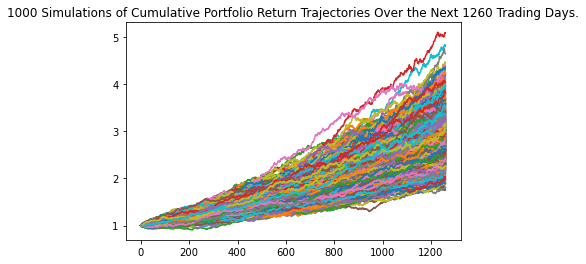

In [188]:
MC_even_dist.plot_simulation()

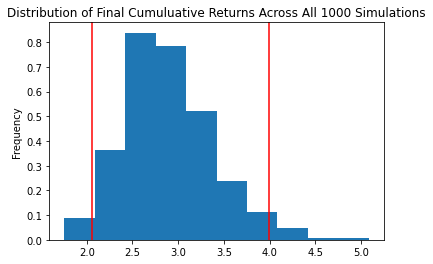

In [154]:
dist_plot = MC_even_dist.plot_distribution() 

In [155]:
even_tbl = MC_even_dist.summarize_cumulative_return()


In [156]:
print(even_tbl) 

count           1000.000000
mean               2.888197
std                0.488723
min                1.754472
25%                2.548880
50%                2.827358
75%                3.180848
max                5.083936
95% CI Lower       2.056070
95% CI Upper       3.992467
Name: 1260, dtype: float64


In [157]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in stocks
even_ci_lower = round(even_tbl[8]*10000,2)
even_ci_upper = round(even_tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${even_ci_lower} and ${even_ci_upper}.")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 5 years will end within in the range of $20560.7 and $39924.67.


In [158]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 30% Wal-Mart stock
MC_wal_mart = MCSimulation(
    portfolio_data = winners_df_ticker,
    weights = [.10,.20,.20,.20,.30],
    num_simulation = 1000,
    num_trading_days = 252*5)

# Print the simulation input data
MC_wal_mart.portfolio_data.head()

BRK.B                                   \
                             open    high     low   close   volume   
time                                                                 
2020-07-30 00:00:00-04:00  193.43  194.57  192.25  194.30  7833392   
2020-07-31 00:00:00-04:00  195.06  196.00  193.33  195.82  9690065   
2020-08-03 00:00:00-04:00  197.28  200.11  196.00  199.14  8444685   
2020-08-04 00:00:00-04:00  198.97  200.31  198.11  200.31  6409839   
2020-08-05 00:00:00-04:00  201.44  204.69  201.00  203.62  9195934   

                                           JNJ                            ...  \
                          daily_return    open    high       low   close  ...   
time                                                                      ...   
2020-07-30 00:00:00-04:00          NaN  147.44  147.50  146.1400  146.91  ...   
2020-07-31 00:00:00-04:00     0.007823  146.66  147.45  143.9600  145.83  ...   
2020-08-03 00:00:00-04:00     0.016954  146.39  147.58  146.1500  147.35  ...   
2020-08-04 00:00:00-04:00     0.005875  146.99  147.22  145.8247  147.21  ...   
2020-08-05 00:00:00-04:00     0.016524  149.10  149.31  147.8000  148.39  ...   

                              SPY                                     WMT  \
                              low   close     volume daily_return    open   
time                                                                        
2020-07-30 00:00:00-04:00  319.64  323.98  106103025          NaN  129.42   
2020-07-31 00:00:00-04:00  321.33  326.55  129516546     0.007933  129.65   
2020-08-03 00:00:00-04:00  327.73  328.76   71741125     0.006768  129.91   
2020-08-04 00:00:00-04:00  327.86  330.03   73684427     0.003863  129.65   
2020-08-05 00:00:00-04:00  331.18  332.06   72846458     0.006151  130.45   

                                                                             
                              high       low   close    volume daily_return  
time                                                                         
2020-07-30 00:00:00-04:00  130.420  128.7200  130.11   8392139          NaN  
2020-07-31 00:00:00-04:00  130.090  127.6200  129.43  11376858    -0.005226  
2020-08-03 00:00:00-04:00  130.115  128.2713  129.30   7181839    -0.001004  
2020-08-04 00:00:00-04:00  131.710  128.9400  131.62  11032656     0.017943  
2020-08-05 00:00:00-04:00  130.750  128.8300  129.80  15735392    -0.013828  

[5 rows x 30 columns]

In [186]:
wal_closing_prices = pd.DataFrame()

# Fetch the closing prices for all the tickers
for ticker in tickers:
    wal_closing_prices[ticker] = winners_df_ticker[ticker]["close"]

# Drop the time component of the date
wal_closing_prices.index = wal_closing_prices.index.date

# Display sample data
wal_closing_prices.head()

,SPY,BRK.B,JNJ,PG,WMT
2020-07-30,323.98,194.30,146.91,131.44,130.11
2020-07-31,326.55,195.82,145.83,131.06,129.43
2020-08-03,328.76,199.14,147.35,131.33,129.30
2020-08-04,330.03,200.31,147.21,133.80,131.62
2020-08-05,332.06,203.62,148.39,133.45,129.80


In [187]:
wal_daily_returns  = wal_closing_prices.pct_change().dropna()
wal_daily_returns.head()

,SPY,BRK.B,JNJ,PG,WMT
2020-07-31,0.007933,0.007823,-0.007351,-0.002891,-0.005226
2020-08-03,0.006768,0.016954,0.010423,0.002060,-0.001004
2020-08-04,0.003863,0.005875,-0.000950,0.018808,0.017943
2020-08-05,0.006151,0.016524,0.008016,-0.002616,-0.013828
2020-08-06,0.006776,0.007219,-0.005661,-0.005545,-0.003467


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

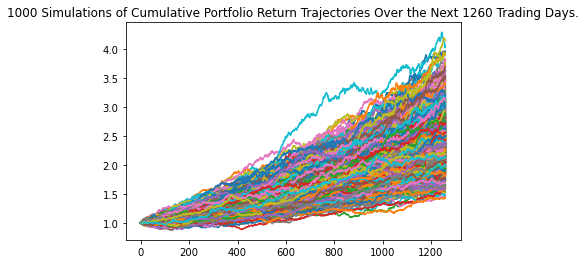

In [185]:
MC_wal_mart.plot_simulation()

5 Years of simulation with Wal_Mart 30%

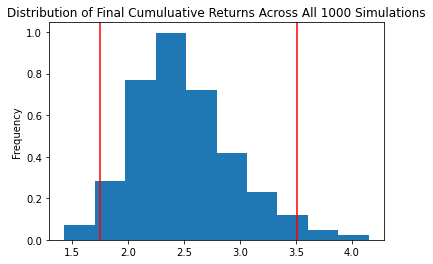

In [184]:
dist_plot = MC_wal_mart.plot_distribution() 

In [163]:
wal_mart_tbl = MC_wal_mart.summarize_cumulative_return()
wal_mart_tbl

count           1000.000000
mean               2.496287
std                0.447315
min                1.431717
25%                2.189399
50%                2.437811
75%                2.750358
max                4.150167
95% CI Lower       1.747907
95% CI Upper       3.514162
Name: 1260, dtype: float64

In [164]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in stocks
wal_mart_ci_lower = round(wal_mart_tbl[8]*10000,2)
wal_mart_ci_upper = round(wal_mart_tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment in Wal-Mart of $10,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${wal_mart_ci_lower} and ${wal_mart_ci_upper}.")

There is a 95% chance that an initial investment in Wal-Mart of $10,000 in the portfolio over the next 5 years will end within in the range of $17479.07 and $35141.62.


In [165]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 30% JNJ stock
MC_JNJ = MCSimulation(
    portfolio_data = winners_df_ticker,
    weights = [.20,.30,.10,.20,.20],
    num_simulation = 1000,
    num_trading_days = 252*5)

# Print the simulation input data
MC_JNJ.portfolio_data.head()

BRK.B                                   \
                             open    high     low   close   volume   
time                                                                 
2020-07-30 00:00:00-04:00  193.43  194.57  192.25  194.30  7833392   
2020-07-31 00:00:00-04:00  195.06  196.00  193.33  195.82  9690065   
2020-08-03 00:00:00-04:00  197.28  200.11  196.00  199.14  8444685   
2020-08-04 00:00:00-04:00  198.97  200.31  198.11  200.31  6409839   
2020-08-05 00:00:00-04:00  201.44  204.69  201.00  203.62  9195934   

                                           JNJ                            ...  \
                          daily_return    open    high       low   close  ...   
time                                                                      ...   
2020-07-30 00:00:00-04:00          NaN  147.44  147.50  146.1400  146.91  ...   
2020-07-31 00:00:00-04:00     0.007823  146.66  147.45  143.9600  145.83  ...   
2020-08-03 00:00:00-04:00     0.016954  146.39  147.58  146.1500  147.35  ...   
2020-08-04 00:00:00-04:00     0.005875  146.99  147.22  145.8247  147.21  ...   
2020-08-05 00:00:00-04:00     0.016524  149.10  149.31  147.8000  148.39  ...   

                              SPY                                     WMT  \
                              low   close     volume daily_return    open   
time                                                                        
2020-07-30 00:00:00-04:00  319.64  323.98  106103025          NaN  129.42   
2020-07-31 00:00:00-04:00  321.33  326.55  129516546     0.007933  129.65   
2020-08-03 00:00:00-04:00  327.73  328.76   71741125     0.006768  129.91   
2020-08-04 00:00:00-04:00  327.86  330.03   73684427     0.003863  129.65   
2020-08-05 00:00:00-04:00  331.18  332.06   72846458     0.006151  130.45   

                                                                             
                              high       low   close    volume daily_return  
time                                                                         
2020-07-30 00:00:00-04:00  130.420  128.7200  130.11   8392139          NaN  
2020-07-31 00:00:00-04:00  130.090  127.6200  129.43  11376858    -0.005226  
2020-08-03 00:00:00-04:00  130.115  128.2713  129.30   7181839    -0.001004  
2020-08-04 00:00:00-04:00  131.710  128.9400  131.62  11032656     0.017943  
2020-08-05 00:00:00-04:00  130.750  128.8300  129.80  15735392    -0.013828  

[5 rows x 30 columns]

In [166]:
jnj_closing_prices = pd.DataFrame()

# Fetch the closing prices for all the tickers
for ticker in tickers:
    jnj_closing_prices[ticker] = winners_df_ticker[ticker]["close"]

# Drop the time component of the date
jnj_closing_prices.index = jnj_closing_prices.index.date

# Display sample data
jnj_closing_prices.head()

,SPY,BRK.B,JNJ,PG,WMT
2020-07-30,323.98,194.30,146.91,131.44,130.11
2020-07-31,326.55,195.82,145.83,131.06,129.43
2020-08-03,328.76,199.14,147.35,131.33,129.30
2020-08-04,330.03,200.31,147.21,133.80,131.62
2020-08-05,332.06,203.62,148.39,133.45,129.80


In [167]:
jnj_daily_returns  = jnj_closing_prices.pct_change().dropna()
jnj_daily_returns.head()

,SPY,BRK.B,JNJ,PG,WMT
2020-07-31,0.007933,0.007823,-0.007351,-0.002891,-0.005226
2020-08-03,0.006768,0.016954,0.010423,0.002060,-0.001004
2020-08-04,0.003863,0.005875,-0.000950,0.018808,0.017943
2020-08-05,0.006151,0.016524,0.008016,-0.002616,-0.013828
2020-08-06,0.006776,0.007219,-0.005661,-0.005545,-0.003467


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

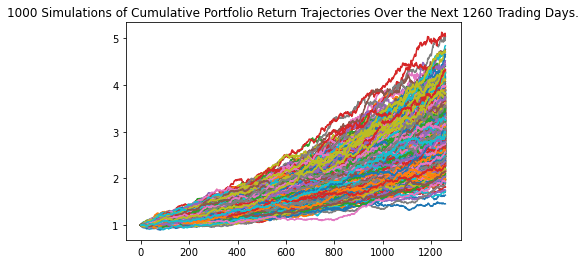

In [168]:
MC_JNJ.plot_simulation()

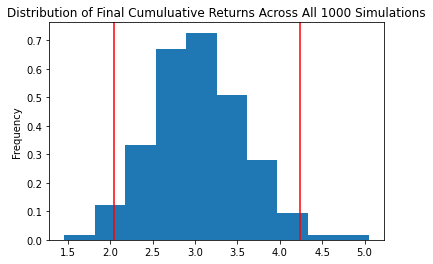

In [169]:
jnj_plot = MC_JNJ.plot_distribution() 

In [170]:
jnj_tbl = MC_JNJ.summarize_cumulative_return()
jnj_tbl

count           1000.000000
mean               3.035142
std                0.545056
min                1.457624
25%                2.653967
50%                3.001118
75%                3.384801
max                5.049058
95% CI Lower       2.046650
95% CI Upper       4.237339
Name: 1260, dtype: float64

In [171]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in stocks
jnj_ci_lower = round(jnj_tbl[8]*10000,2)
jnj_ci_upper = round(jnj_tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment in JNJ of $10,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${jnj_ci_lower} and ${jnj_ci_upper}.")

There is a 95% chance that an initial investment in JNJ of $10,000 in the portfolio over the next 5 years will end within in the range of $20466.5 and $42373.39.


In [182]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 30% BRK.B stock
MC_BRK = MCSimulation(
    portfolio_data = winners_df_ticker,
    weights = [.30,.20,.10,.20,.20],
    num_simulation = 1000,
    num_trading_days = 252*5)

# Print the simulation input data
MC_BRK.portfolio_data.head()

BRK.B                                   \
                             open    high     low   close   volume   
time                                                                 
2020-07-30 00:00:00-04:00  193.43  194.57  192.25  194.30  7833392   
2020-07-31 00:00:00-04:00  195.06  196.00  193.33  195.82  9690065   
2020-08-03 00:00:00-04:00  197.28  200.11  196.00  199.14  8444685   
2020-08-04 00:00:00-04:00  198.97  200.31  198.11  200.31  6409839   
2020-08-05 00:00:00-04:00  201.44  204.69  201.00  203.62  9195934   

                                           JNJ                            ...  \
                          daily_return    open    high       low   close  ...   
time                                                                      ...   
2020-07-30 00:00:00-04:00          NaN  147.44  147.50  146.1400  146.91  ...   
2020-07-31 00:00:00-04:00     0.007823  146.66  147.45  143.9600  145.83  ...   
2020-08-03 00:00:00-04:00     0.016954  146.39  147.58  146.1500  147.35  ...   
2020-08-04 00:00:00-04:00     0.005875  146.99  147.22  145.8247  147.21  ...   
2020-08-05 00:00:00-04:00     0.016524  149.10  149.31  147.8000  148.39  ...   

                              SPY                                     WMT  \
                              low   close     volume daily_return    open   
time                                                                        
2020-07-30 00:00:00-04:00  319.64  323.98  106103025          NaN  129.42   
2020-07-31 00:00:00-04:00  321.33  326.55  129516546     0.007933  129.65   
2020-08-03 00:00:00-04:00  327.73  328.76   71741125     0.006768  129.91   
2020-08-04 00:00:00-04:00  327.86  330.03   73684427     0.003863  129.65   
2020-08-05 00:00:00-04:00  331.18  332.06   72846458     0.006151  130.45   

                                                                             
                              high       low   close    volume daily_return  
time                                                                         
2020-07-30 00:00:00-04:00  130.420  128.7200  130.11   8392139          NaN  
2020-07-31 00:00:00-04:00  130.090  127.6200  129.43  11376858    -0.005226  
2020-08-03 00:00:00-04:00  130.115  128.2713  129.30   7181839    -0.001004  
2020-08-04 00:00:00-04:00  131.710  128.9400  131.62  11032656     0.017943  
2020-08-05 00:00:00-04:00  130.750  128.8300  129.80  15735392    -0.013828  

[5 rows x 30 columns]

In [173]:
brk_closing_prices = pd.DataFrame()

# Fetch the closing prices for all the tickers
for ticker in tickers:
    brk_closing_prices[ticker] = winners_df_ticker[ticker]["close"]

# Drop the time component of the date
brk_closing_prices.index = brk_closing_prices.index.date

# Display sample data
brk_closing_prices.head()

,SPY,BRK.B,JNJ,PG,WMT
2020-07-30,323.98,194.30,146.91,131.44,130.11
2020-07-31,326.55,195.82,145.83,131.06,129.43
2020-08-03,328.76,199.14,147.35,131.33,129.30
2020-08-04,330.03,200.31,147.21,133.80,131.62
2020-08-05,332.06,203.62,148.39,133.45,129.80


In [174]:
brk_daily_returns  = brk_closing_prices.pct_change().dropna()
brk_daily_returns.head()

,SPY,BRK.B,JNJ,PG,WMT
2020-07-31,0.007933,0.007823,-0.007351,-0.002891,-0.005226
2020-08-03,0.006768,0.016954,0.010423,0.002060,-0.001004
2020-08-04,0.003863,0.005875,-0.000950,0.018808,0.017943
2020-08-05,0.006151,0.016524,0.008016,-0.002616,-0.013828
2020-08-06,0.006776,0.007219,-0.005661,-0.005545,-0.003467


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

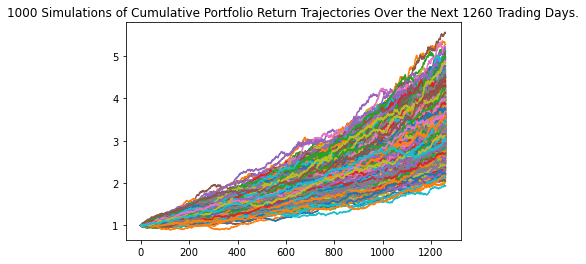

In [175]:
MC_BRK.plot_simulation()

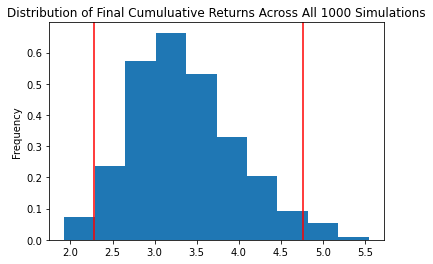

In [176]:
brk_plot = MC_BRK.plot_distribution() 

In [177]:
brk_tbl = MC_BRK.summarize_cumulative_return()
brk_tbl

count           1000.000000
mean               3.351458
std                0.621777
min                1.927228
25%                2.909823
50%                3.285541
75%                3.729183
max                5.543955
95% CI Lower       2.276019
95% CI Upper       4.763522
Name: 1260, dtype: float64

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in stocks
brk_ci_lower = round(brk_tbl[8]*10000,2)
brk_ci_upper = round(brk_tbl[9]*10000,2)

In [ ]:
# Print results
print(f"There is a 95% chance that an initial investment in BRK of $10,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${brk_ci_lower} and ${brk_ci_upper}.")

In [179]:
print(f"There is a 95% chance that an initial investment in JNJ of $10,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${jnj_ci_lower} and ${jnj_ci_upper}.")

There is a 95% chance that an initial investment in JNJ of $10,000 in the portfolio over the next 5 years will end within in the range of $20466.5 and $42373.39.


In [180]:
print(f"There is a 95% chance that an initial investment in Wal-Mart of $10,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${wal_mart_ci_lower} and ${wal_mart_ci_upper}.")

There is a 95% chance that an initial investment in Wal-Mart of $10,000 in the portfolio over the next 5 years will end within in the range of $17479.07 and $35141.62.
